Referência: SOUSA, A. Willian; DEL FABRO, Marcos Didonet. Iudicium textum dataset uma base de textos jurıdicos para nlp. In: XXXIV Simpósio Brasileiro de Banco de Dados: Dataset Showcase Workshop, SBBD. 2019.

In [1]:
import json
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

total de words 233


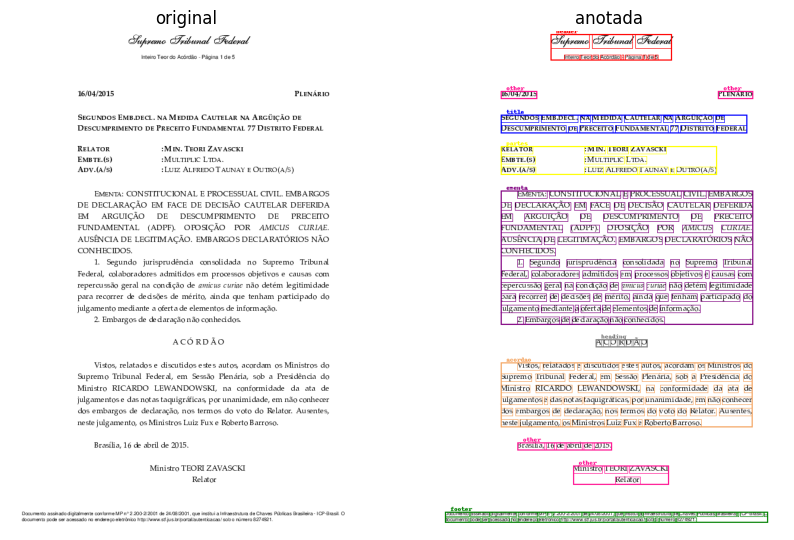

In [2]:
image = Image.open("data/training_data/images/77.png")
image = image.convert("RGB")
image_an = image.copy()
draw = ImageDraw.Draw(image_an, "RGBA")

font = ImageFont.load_default()

label2color = {'header':'red', 'title': 'blue', 'footer':'green','other':'deeppink','ementa':'purple','acordao':'sandybrown','partes':'yellow', 'heading':'grey'}
i = 0
with open('data/training_data/annotations/77.json') as f:
  data = json.load(f)
for annotation in data['form']:
  label = annotation['label']
  general_box = annotation['box']
  draw.rectangle(general_box, outline=label2color[label], width=2)
  draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
  words = annotation['words']
  for word in words:
    box = word['box']
    draw.rectangle(box, outline=label2color[label], width=1)
    i+=1
print('total de words', i)
f, axarr = plt.subplots(1,2,figsize=(10, 10))

axarr = axarr.flatten()
axarr[0].imshow(image)
axarr[0].axis('off')
axarr[0].set_title('original')
axarr[1].imshow(image_an)
axarr[1].axis('off')
axarr[1].set_title('anotada')
plt.show()

In [3]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlmdatasets/visualml2/data_set
! pip install unilm/layoutlm

Cloning into 'unilm'...
remote: Enumerating objects: 6824, done.
remote: Total 6824 (delta 0), reused 0 (delta 0), pack-reused 6824
Receiving objects: 100% (6824/6824), 14.68 MiB | 6.49 MiB/s, done.
Resolving deltas: 100% (2934/2934), done.
/bin/bash: line 0: cd: unilm/layoutlmdatasets/visualml2/data_set: No such file or directory
Processing ./unilm/layoutlm
  Using cached transformers-2.9.0-py3-none-any.whl (635 kB)
  Using cached tokenizers-0.7.0-cp38-cp38-manylinux1_x86_64.whl (7.5 MB)
  Created wheel for layoutlm: filename=layoutlm-0.0-py3-none-any.whl size=11463 sha256=448a538a4e94e7c81e27e1c1c5fdde1b6746170aff5627b6f0a559084cd50e3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-r9szkbw6/wheels/26/e2/34/f60e371c41f4b04d0730673b044a262f33cef7175572f2cb26
Successfully built layoutlm
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.2
    Uninstalling tokenizers-0.13.2:
      Successfully uninstalled tokenizers-0.13.2
  Attempting uninstall: trans

In [4]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

Cloning into 'transformers'...
remote: Enumerating objects: 127957, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (222/222), done.
^Cceiving objects:  64% (81893/127957), 98.14 MiB | 2.98 MiB/s
/bin/bash: line 0: cd: transformers: No such file or directory
ERROR: Invalid requirement: './transformers'
Hint: It looks like a path. File './transformers' does not exist.


Referência: ROGGE, Niels.  Nielsrogge/UNILM: UNILM - Unified Language Model Pre-training / pre-training for NLP and beyond. GitHub. Retrieved February 1, 2023, from https://github.com/NielsRogge/unilm 

In [ ]:
!python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/training_data/annotations \
                                                      --data_split train \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 512

!python unilm/layoutlm/examples/seq_labeling/preprocess.py --data_dir data/testing_data/annotations \
                                                      --data_split test \
                                                      --output_dir data \
                                                      --model_name_or_path microsoft/layoutlm-base-uncased \
                                                      --max_len 512

In [ ]:
!cat data/train.txt | cut -d$'\t' -f 2 | grep -v "^$"| sort | uniq > data/labels.txt

In [ ]:
import json
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

In [ ]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("data/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

In [ ]:
print(labels)

['B-ACORDAO', 'B-EMENTA', 'B-FOOTER', 'B-HEADER', 'B-HEADING', 'B-PARTES', 'B-TITLE', 'E-ACORDAO', 'E-EMENTA', 'E-FOOTER', 'E-HEADER', 'E-HEADING', 'E-PARTES', 'E-TITLE', 'I-ACORDAO', 'I-EMENTA', 'I-FOOTER', 'I-HEADER', 'I-HEADING', 'I-PARTES', 'I-TITLE', 'O', 'S-HEADING']


In [ ]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': 'data',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# Os criadores do LayoutLM definiram um dataset FunsdDataset o código foi levemente alterado para se adequar ao problema
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=8)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=8)

In [ ]:
print(len(train_dataloader),len(eval_dataloader))

144 36


In [ ]:
from transformers import LayoutLMForTokenClassification,LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
from transformers import AdamW
from tqdm import tqdm
losses = []
#optimizer = AdamW(model.parameters(), lr=0.00005)
optimizer = AdamW(model.parameters(), lr=0.00005)
global_step = 0
num_train_epochs = 3
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss
      losses.append(loss)

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:346: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   1%|          | 1/144 [00:01<03:18,  1.39s/it]

Loss after 0 steps: 3.1343696117401123


Training:  70%|███████   | 101/144 [00:23<00:09,  4.61it/s]

Loss after 100 steps: 0.09412454068660736


Training:  40%|███▉      | 57/144 [00:12<00:19,  4.57it/s]

Loss after 200 steps: 0.020543172955513


Training:   9%|▉         | 13/144 [00:02<00:28,  4.58it/s]

Loss after 300 steps: 0.006778717041015625


Training:  78%|███████▊  | 113/144 [00:24<00:06,  4.54it/s]

Loss after 400 steps: 0.019259251654148102


Training: 100%|██████████| 144/144 [00:31<00:00,  4.59it/s]


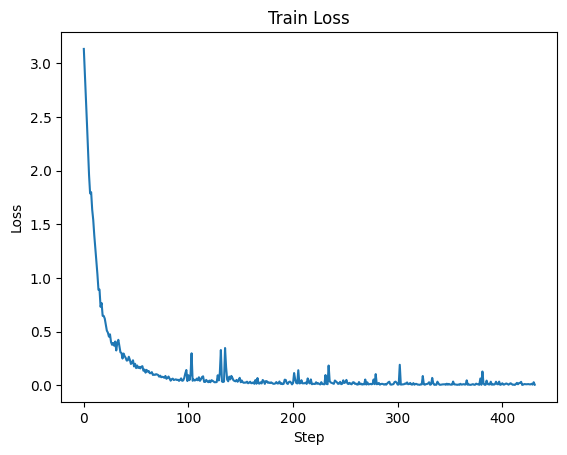

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
losses = [l.item() for l in losses]
x = np.arange(len(losses))
# Dataset
y = losses
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Train Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

In [ ]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None
elosses = []
# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        elosses.append(tmp_eval_loss)
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 36/36 [00:02<00:00, 12.58it/s]


{'loss': 0.01255221238049368, 'precision': 0.9756427604871448, 'recall': 0.9843003412969283, 'f1': 0.9799524294937139}


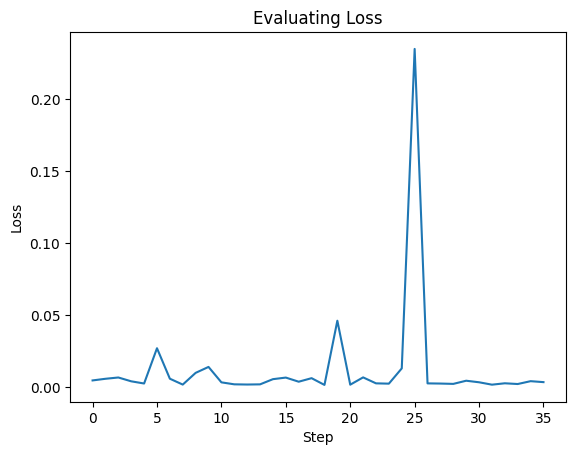

In [ ]:
elosses = [l.item() for l in elosses]
x = np.arange(len(elosses))
# Dataset
y = elosses
 
# Plotting the Graph
plt.plot(x, y)
plt.title("Evaluating Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

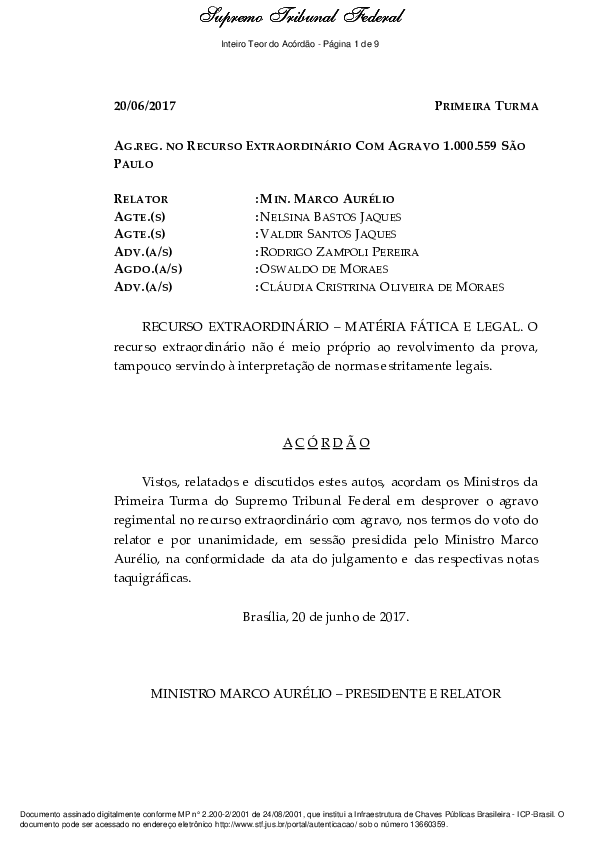

In [33]:
#img_path = "data/testing_data/images/497.png"
img_path ='data/testing_data/images/598.png'
#img_path ='data/testing_data/images/1000559.png'
image = Image.open(img_path)
image = image.convert("RGB")
image

In [34]:
import pdfplumber
def get_words_bboxes(image_path):
    image_path = image_path.split("/")[-1]
    id = image_path.replace('.png','')
    pdf_idtm_path = f'./ITD_MINI/{id}/{id}.pdf'
    with pdfplumber.open(pdf_idtm_path) as pdf:
        word_boxs = pdf.pages[0].dedupe_chars().extract_words()
        words = [w['text'] for w in word_boxs]
        bboxes = [[round(w['x0']),round(w['top']),round(w['x1']),round(w['bottom'])] for w in word_boxs]
        return words,bboxes

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]
        

In [35]:
width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

In [36]:
words,actual_boxes = get_words_bboxes(img_path)
del words[3:5]
del actual_boxes[3:5]
print(words[:6],actual_boxes[:6])

['SSuupprreemmoo', 'TTrriibbuunnaall', 'FFeeddeerraall', 'Inteiro', 'Teor', 'do'] [[198, 5, 263, 29], [268, 5, 336, 29], [341, 5, 402, 29], [221, 40, 246, 49], [248, 40, 267, 49], [269, 40, 279, 49]]


In [37]:
print(len(words))

181


In [38]:
boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes[:3]

[[332, 5, 442, 34], [450, 5, 564, 34], [573, 5, 675, 34]]

In [39]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [40]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [41]:
tokenizer.decode(input_ids)

'[CLS] ssuupprreemmoo ttrriibbuunnaall ffeeddeerraall inteiro teor do acordao - pagina 1 de 9 20 / 06 / 2017 primeira turma ag. reg. no recurso extraordinario com agravo 1. 000. 559 sao paulo relator : min. marco aurelio agte. ( s ) : nelsina bastos jaques agte. ( s ) : valdir santos jaques adv. ( a / s ) : rodrigo zampoli pereira agdo. ( a / s ) : oswaldo de moraes adv. ( a / s ) : claudia cristrina oliveira de moraes recurso extraordinario – materia fatica e legal. o recurso extraordinario nao e meio proprio ao revolvimento da prova, tampouco servindo a interpretacao de normas estritamente legais. a c o r d a o vistos, relatados e discutidos estes autos, acordam os ministros da primeira turma do supremo tribunal federal em desprover o agravo regimental no recurso extraordinario com agravo, nos termos do voto do relator e por unanimidade, em sessao presidida pelo ministro marco aurelio, na conformidade da ata do julgamento e das respectivas notas taquigraficas. brasilia, 20 de junho d

In [42]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
(input_ids.shape,attention_mask.shape,token_type_ids.shape,bbox.shape)

(torch.Size([1, 512]),
 torch.Size([1, 512]),
 torch.Size([1, 512]),
 torch.Size([1, 512, 4]))

In [43]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs

TokenClassifierOutput(loss=None, logits=tensor([[[-0.1125, -0.2436,  0.0062,  ..., -1.0061,  2.3045,  0.4962],
         [-0.1732, -0.5175,  0.1359,  ..., -1.1780, -0.2208,  0.3627],
         [-0.7224, -0.6198, -0.5995,  ..., -0.6418,  0.1610, -0.1913],
         ...,
         [-0.4739, -0.7489,  0.4550,  ...,  0.2597,  0.0490, -0.4595],
         [-0.7204, -0.7931,  0.4486,  ...,  0.0235,  0.5285, -0.6079],
         [-0.6873, -1.0780,  0.0589,  ...,  0.2813,  3.8652, -0.9311]]],
       device='cuda:0', grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [44]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    if box not in final_boxes:
      word_level_predictions.append(token_pred)
      final_boxes.append(box)


print(word_level_predictions)

[3, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 10, 21, 21, 21, 6, 20, 20, 20, 20, 20, 20, 20, 13, 5, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 12, 1, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 8, 4, 18, 18, 18, 18, 18, 11, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 7, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 2, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9]


In [45]:
print(len(word_level_predictions))

181


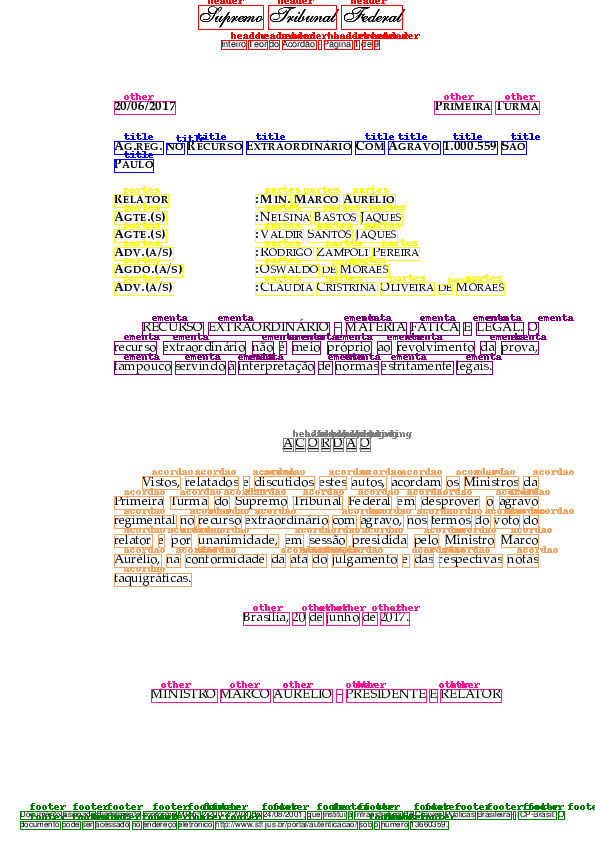

In [54]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return "other"

label2color = {'header':'red', 'title': 'blue', 'footer':'green','other':'deeppink','ementa':'purple','acordao':'sandybrown','partes':'yellow', 'heading':'grey'}
for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image